In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
register_matplotlib_converters()
from time import time

In [3]:
def parser(s):
    return datetime.strptime(s, '%m/%d/%Y')

In [4]:
#read data
series = pd.read_csv('C:/python/inflation_canada.csv', parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

In [5]:
start_date = datetime(1989,1,1)
end_date = datetime(2021,3,1)
lim_series = series[start_date:end_date]

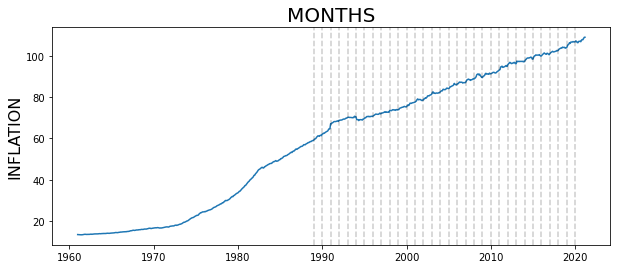

In [6]:
plt.figure(figsize=(10,4))
plt.plot(series)
plt.title('MONTHS', fontsize=20)
plt.ylabel('INFLATION', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [7]:
first_diff = lim_series.diff()[1:]

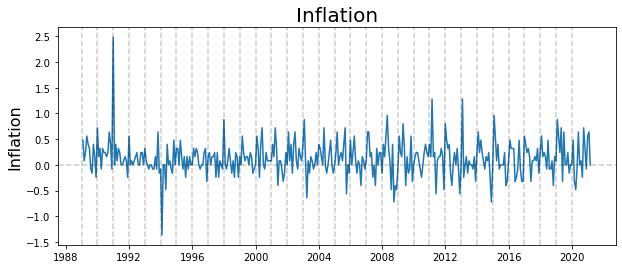

In [8]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Inflation', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


<BarContainer object of 20 artists>

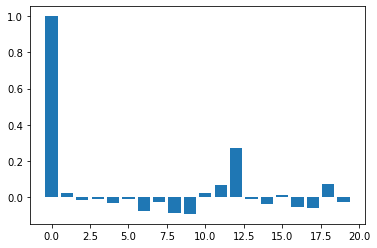

In [9]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\stattools.py:1029: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs // 2 - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  FutureWarning,


<BarContainer object of 15 artists>

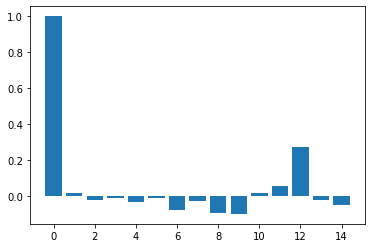

In [10]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [11]:
train_end = datetime(2011,6,1)
test_end = datetime(2021,3,1)

train_data = lim_series[:train_end]
test_data = lim_series[train_end + timedelta(days=1):test_end]

In [12]:
model = ARIMA(train_data, order=(3, 1, 1))  
fitted = model.fit()  
print(fitted.summary())

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:                 Canada   No. Observations:                  270
Model:                 ARIMA(3, 1, 1)   Log Likelihood                 -84.209
Date:                Sat, 31 Jul 2021   AIC                            178.418
Time:                        01:04:22   BIC                            196.392
Sample:                    01-01-1989   HQIC                           185.636
                         - 06-01-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0065      0.076     13.268      0.000       0.858       1.155
ar.L2          0.0538      0.107      0.501      0.617      -0.157       0.264
ar.L3         -0.0603      0.073     -0.831      0.4

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [13]:
predictions = model.fit().forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data - predictions


C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


Text(0, 0.5, 'Error')

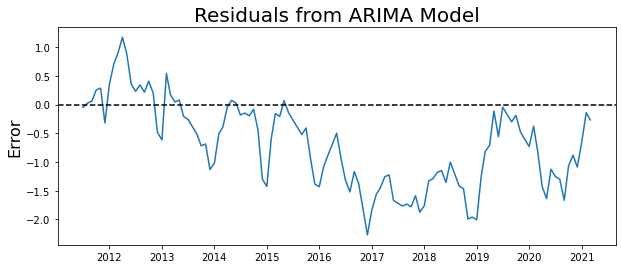

In [14]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

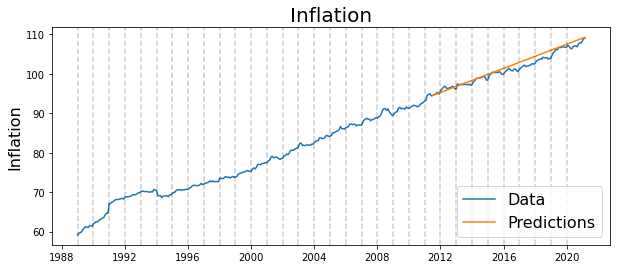

In [15]:
plt.figure(figsize=(10,4))

plt.plot(lim_series)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Inflation', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [16]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test_data)),4))
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Mean Absolute Percent Error: 0.0081
Root Mean Squared Error: 1.018027055428011


In [17]:
rolling_predictions = test_data.copy()
for train_end in test_data.index:
    train_data = lim_series[:train_end-timedelta(days=1)]
    model = ARIMA(train_data, order=(3, 1, 1))  
    fitted = model.fit()  

    #model_fit = model.fit()

    pred = model.fit().forecast()
    rolling_predictions[train_end] = pred

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\hirak\.conda\envs\keras_thaeno\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency 

In [18]:
rolling_residuals = test_data - rolling_predictions


Text(0, 0.5, 'Error')

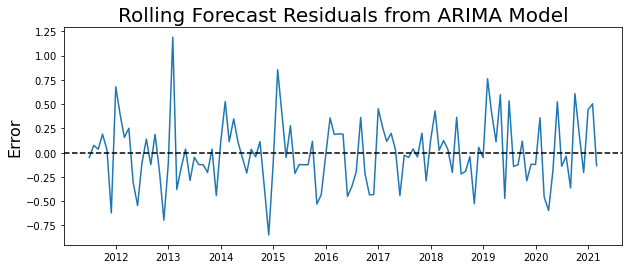

In [19]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from ARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

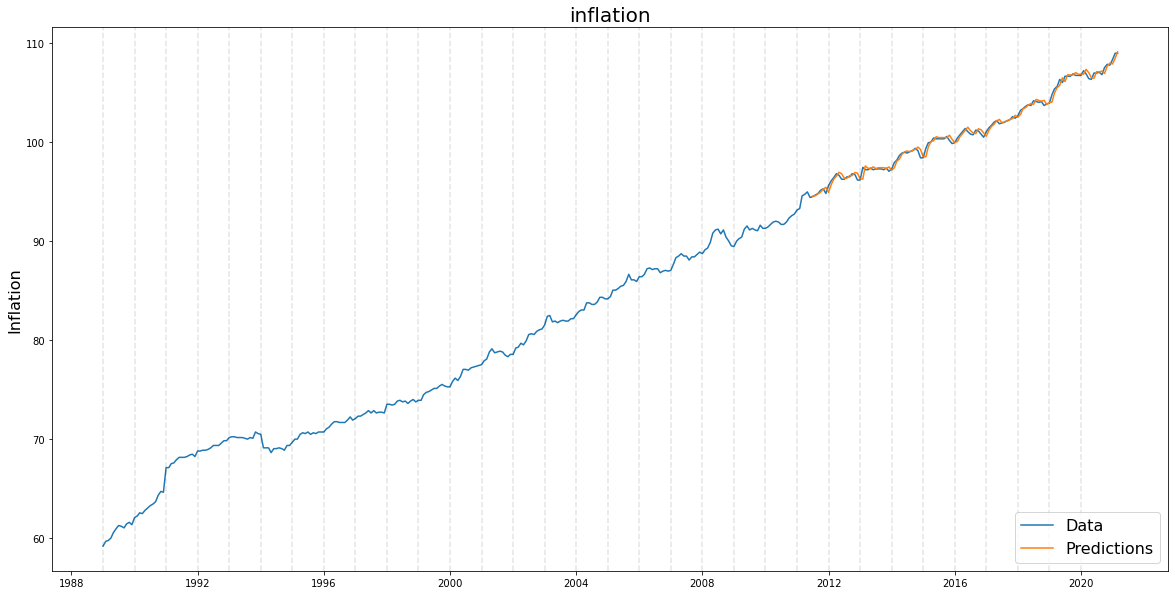

In [20]:
plt.figure(figsize=(20,10))

plt.plot(lim_series)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('inflation', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.10)

DATE
2011-07-01     94.531402
2011-08-01     94.567100
2011-09-01     94.766964
2011-10-01     94.931634
2011-11-01     95.254181
                 ...    
2020-11-01    107.672963
2020-12-01    107.977927
2021-01-01    107.890492
2021-02-01    108.470841
2021-03-01    109.109016
Name: Canada, Length: 117, dtype: float64 DATE
2011-07-01     94.481884
2011-08-01     94.642023
2011-09-01     94.802162
2011-10-01     95.122439
2011-11-01     95.282578
                 ...    
2020-11-01    107.853473
2020-12-01    107.773404
2021-01-01    108.333889
2021-02-01    108.974445
2021-03-01    108.974445
Name: Canada, Length: 117, dtype: float64


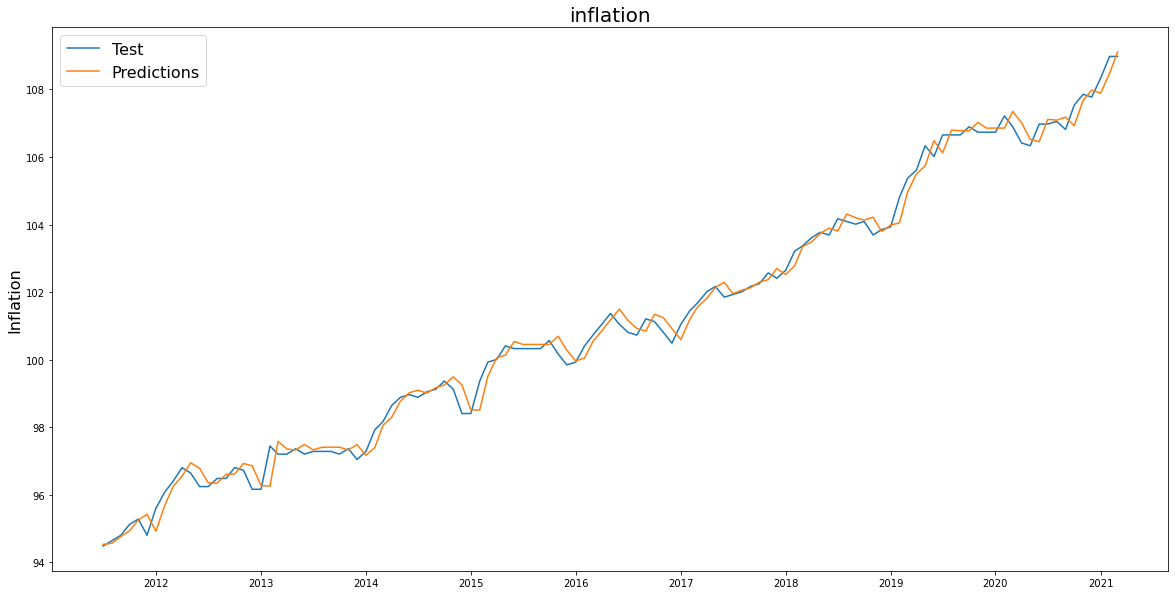

In [26]:
plt.figure(figsize=(20,10))

plt.plot(test_data)
plt.plot(rolling_predictions)

plt.legend(('Test','Predictions'), fontsize=16)

plt.title('inflation', fontsize=20)
plt.ylabel('Inflation', fontsize=16)
print(rolling_predictions, test_data)
#for year in range(test_date.year):
#plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.10)